In [1]:
import numpy as np
import torch
import torch.nn as nn
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Lokta-Volterra system
\begin{cases}
& \frac{dx}{dt} = \alpha x - \beta xy\\
& \frac{dy}{dt} = -\delta y + \gamma xy
\end{cases}

Initial conditions: $x_0, y_0 = (0.44249296, 4.6280594)$

Parameters: $\alpha = 1.3 \\ \beta = 0.9\\ \gamma = 0.8\\ \delta =1.8$

In [2]:
alpha, beta, gamma, delta = (1.3,0.9,0.8,1.8)
x0, y0 = (0.44249296, 4.6280594)
time_int = [0,3]

In [3]:
class LotkaVolterraSystem:
    def __init__(self, alpha, beta, delta, gamma, X):
        self.alpha, self.beta, self.delta, self.gamma = alpha, beta, delta, gamma
        self.X = X
        
    def model(X, t, alpha, beta, delta, gamma):
        x, y = X
        dxdt = x * (alpha - beta * y)
        dydt = y * (-delta + gamma * x)
        return np.array([dxdt, dydt])
    
    def solve(self, t):
        res = odeint(LotkaVolterraSystem.model, self.X, t, args = (self.alpha, self.beta, self.delta, self.gamma))
        return res

In [4]:
LV = LotkaVolterraSystem(alpha=alpha, beta=beta, delta=delta, gamma=gamma, X=[x0,y0])

In [5]:
10**6

1000000

In [6]:
10**4

10000

In [7]:
# Test
test_int = [0,15]
Np_test = 10**3
t_test = torch.linspace(test_int[0], test_int[1], Np_test)

sol_test = LV.solve(t=t_test)
x_test, y_test = sol_test.T
t_test = t_test.requires_grad_(True)

In [8]:
# Train
train_int = [0,3]
Np_train = 10*2
t_train = torch.linspace(train_int[0], train_int[1], Np_train)

sol_train = LV.solve(t=t_train)
x_train, y_train = sol_train.T
t_train = t_train.requires_grad_(True)

$$
(x_i)_{noise} =x_i +\epsilon \cdot \bar{x} \cdot N(0,1)
$$
$$
(y_i)_{noise} =y_i +\epsilon \cdot \bar{y} \cdot N(0,1)
$$

where $\bar{x}$ denotes the element-wise mean of $x_i$ over all $i$ and similarly for $\bar{y}$.

In [9]:
eps = 5e-3

def get_noisy_measurements(n, xi, yi, t, eps):
    bar_x = np.mean(xi)
    bar_y = np.mean(yi)
    
    assert n <= len(t)
    
    step = len(t)//n

    indices = np.arange(0, len(t), step)[:n]

    x = xi[indices]
    y = yi[indices]
    x = x + eps * bar_x * np.random.normal(loc=0.0, scale=1.0, size=len(x))
    y = y + eps * bar_y * np.random.normal(loc=0.0, scale=1.0, size=len(y))
    
    # TODO check, noise is veeeeery low
#     print(y - yi[indices])
    
    # TODO check the spacing 
    return torch.vstack([torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)]), t[indices]

In [10]:
# type(measurements_t)

In [11]:
measurements, measurements_t = get_noisy_measurements(20, x_test, y_test, t_test, eps)

In [12]:
# measurements.shape
# measurements_t.backward(torch.ones_like(measurements_t))

Text(0.5, 1.0, 'Training points')

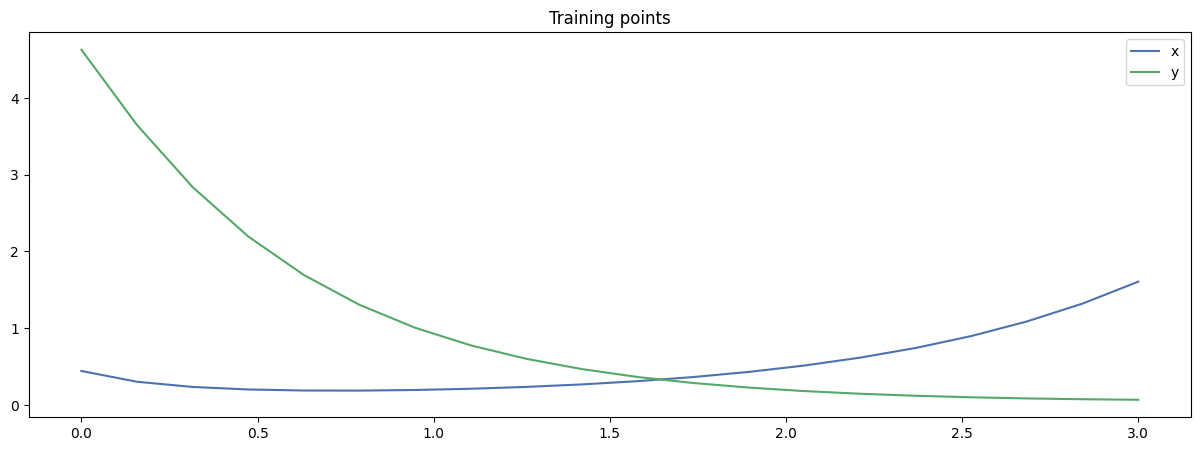

In [14]:
plt.style.use("seaborn-v0_8-deep")
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(t_train.detach().numpy(), x_train, label='x')
ax.plot(t_train.detach().numpy(), y_train, label='y')
# ax.scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisy measurement x')
# ax.scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisy measurement y')
ax.scatter
ax.legend()
ax.set_title('Training points')

Text(0.5, 1.0, 'Test ')

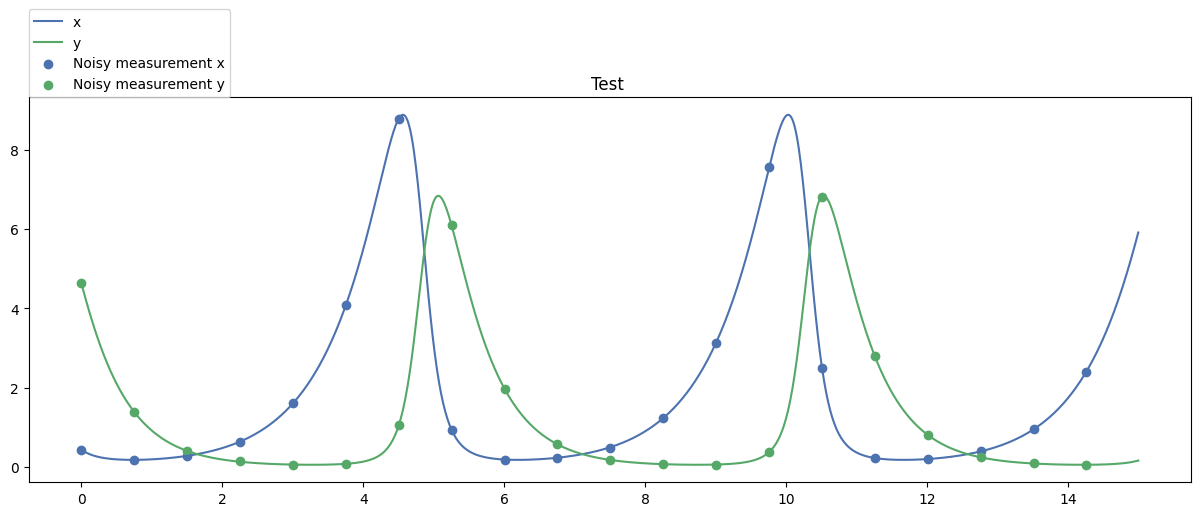

In [15]:
plt.style.use("seaborn-v0_8-deep")
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(t_test.detach().numpy(), x_test, label='x')
ax.plot(t_test.detach().numpy(), y_test, label='y')
ax.scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisy measurement x')
ax.scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisy measurement y')
ax.legend(loc=(0,1))
ax.set_title('Test ')

In [16]:
"""
Lotka-Volterra and Apoptosis model: 
    one input for t followed by a scaling layer; 2 
    hidden layers of 64 units for the surrogate 
    solution; 2 hidden layers of 16 units for the hidden 
    component approximation; sigmoid activation
"""

class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1e-2, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias
    
    
class PINN(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
#         self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [78]:
pinn = PINN(1,2,[32,64,64])
pinn = pinn.to(device)

Overall:10660.3798828125, Physics loss: 0.5097670555114746


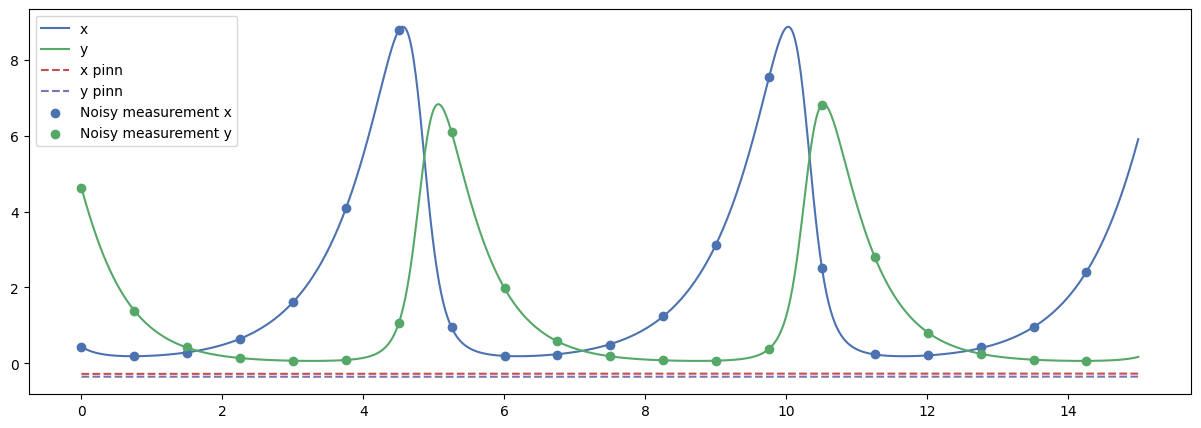

Overall:4590.78857421875, Physics loss: 0.5041200518608093


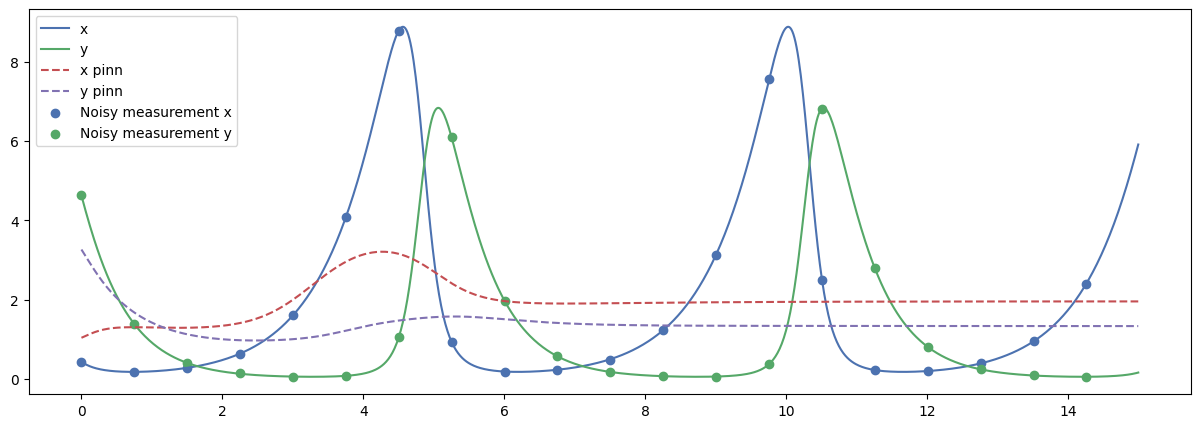

Overall:3983.31884765625, Physics loss: 1.0428087711334229


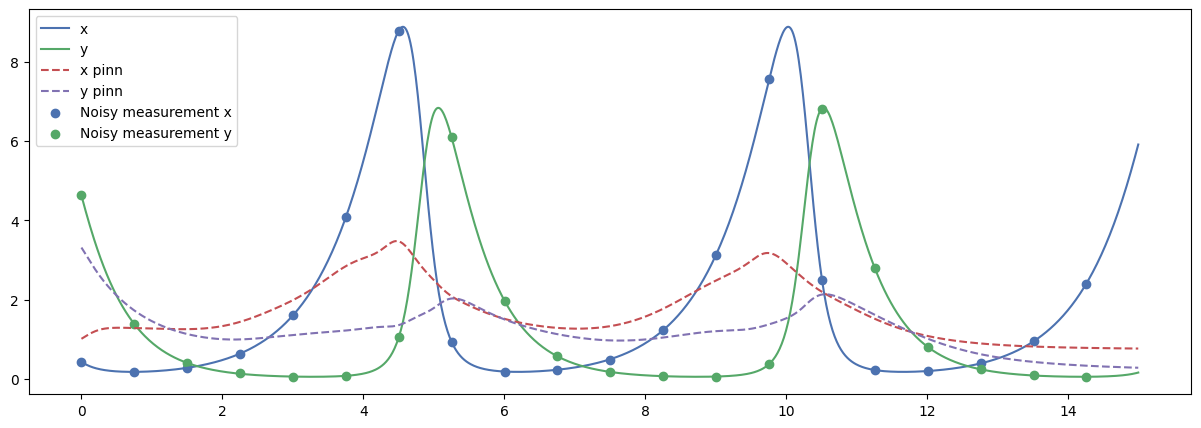

Overall:3951.71240234375, Physics loss: 1.0858864784240723


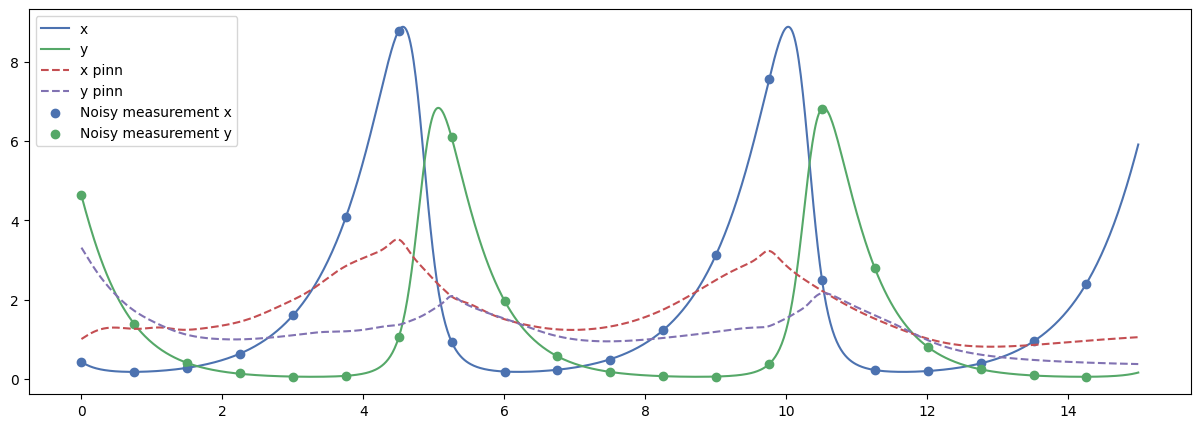

Overall:3932.53759765625, Physics loss: 1.093339443206787


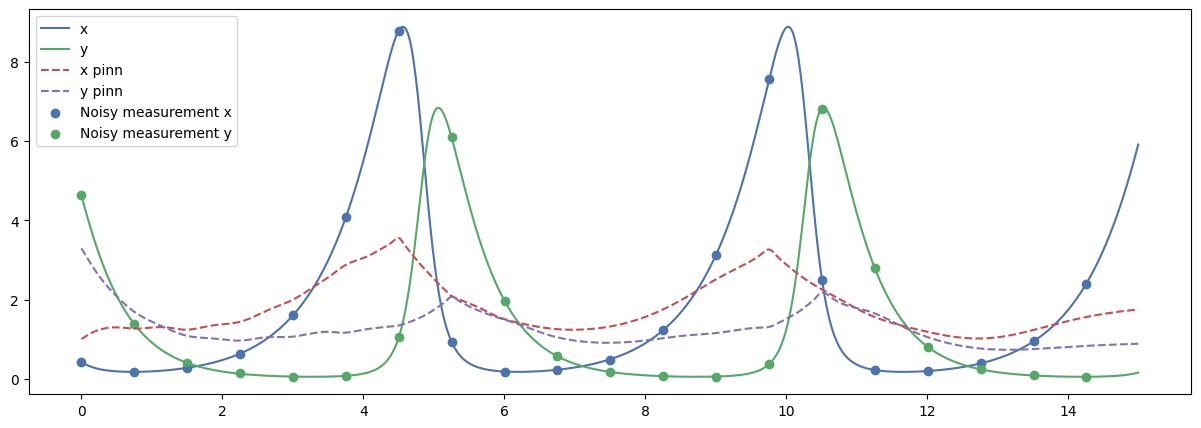

Overall:3928.22607421875, Physics loss: 1.092726707458496


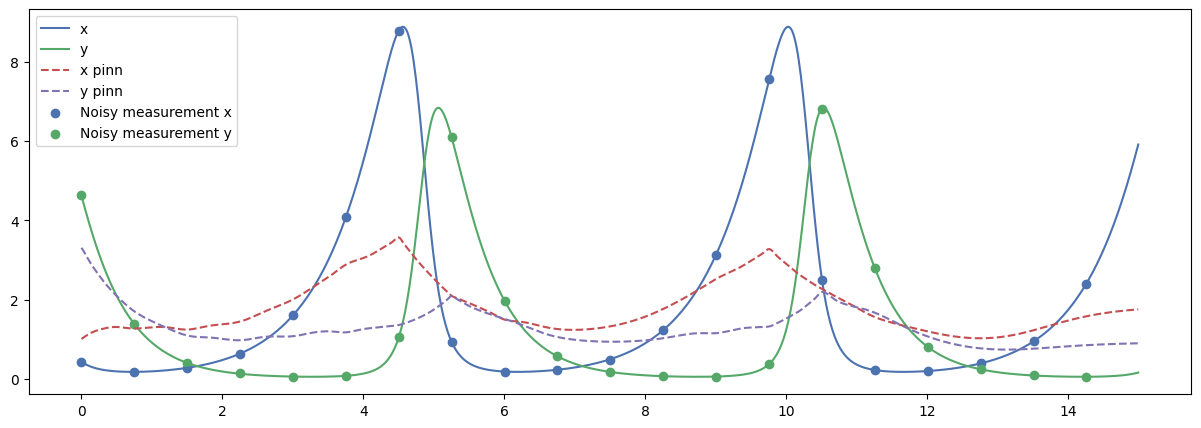

Overall:3924.3125, Physics loss: 1.0976128578186035


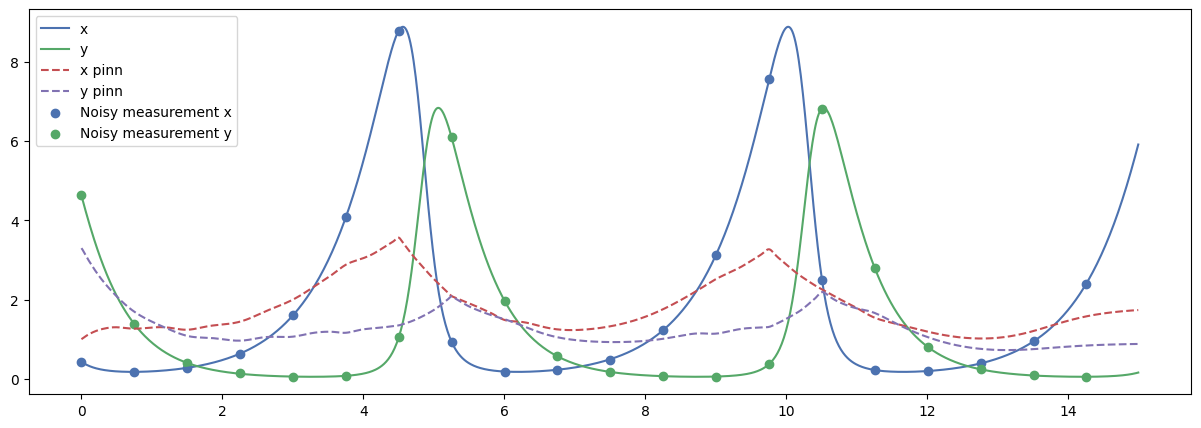

KeyboardInterrupt: 

In [79]:
# Train
lr = 1e-3
optimizer = torch.optim.Adam(pinn.parameters(), lr=lr)
lambda1, lambda2, lambda3 = 1e2, 1e3, 1e3

for i in range(40001):
    optimizer.zero_grad()
    
    # boundary loss
    x0, y0 = LV.X
    t_boundary = 0
    u_b = pinn(torch.Tensor([[t_boundary]]).to(device))
    loss1 = nn.MSELoss()(u_b, torch.Tensor([[LV.X[0],LV.X[1]]]).to(device)) # ensure the initial conditions
    
    # Physics loss
    
    phys_input = t_test.to(device).reshape(-1,1)
    u_p = pinn(phys_input)
    x, y = u_p[:,0], u_p[:,1]
    dxdt = torch.autograd.grad(u_p[:,0], phys_input, torch.ones_like(u_p[:,0]), create_graph=True)[0]
    dydt = torch.autograd.grad(u_p[:,1], phys_input, torch.ones_like(u_p[:,1]), create_graph=True)[0]

#     loss2 = torch.mean(torch.vstack([dxdt - LV.alpha * x + LV.beta * x*y, dydt + LV.delta * y - LV.gamma * x*y])**2)
    dudt = torch.vstack([dxdt - LV.alpha * x + LV.beta * x*y, 
                         dydt + LV.delta * y - LV.gamma * x*y])
    loss2 = nn.MSELoss()(dudt, torch.zeros_like(dudt))
    # should be equal to: nn.MSELoss()(tensor, torch.Tensor([[0,0],[0,0],[0,0],[0,0], ...]))
    
    # Datapoint loss
    u_n = pinn(measurements_t.detach().clone().to(device).reshape(-1,1)) # WHY TF do i need to detach it?????
    #     loss3 = torch.mean((u_n - measurements.T)**2) # equivalent
    loss3 = nn.MSELoss()(u_n, measurements.to(device).T)
    
#     print(loss1.item(), loss2.item(), loss3.item())
    loss = lambda1*loss1 + lambda2*loss2  + lambda3*loss3 ## Why does it break?
    
    loss.backward()
    optimizer.step()
    
    if i% 2000 == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1, figsize=(15,5))
            ax.plot(t_test.detach().cpu().numpy(), x_test, label='x')
            ax.plot(t_test.detach().cpu().numpy(), y_test, label='y')
            print(f'Overall:{loss.item()}, Physics loss: {loss2.item()}')
            
            # pinn
            u_p = pinn(t_test.to(device).reshape(-1,1))
            x, y = u_p[:,0], u_p[:,1]
            ax.plot(t_test.detach().cpu().numpy(), x.cpu(), label='x pinn', linestyle='--')
            ax.plot(t_test.detach().cpu().numpy(), y.cpu(), label='y pinn', linestyle='--')
            ax.scatter(measurements_t.detach().numpy(), measurements[0,:], label='Noisy measurement x')
            ax.scatter(measurements_t.detach().numpy(), measurements[1,:], label='Noisy measurement y')
            ax.legend()
            plt.show()

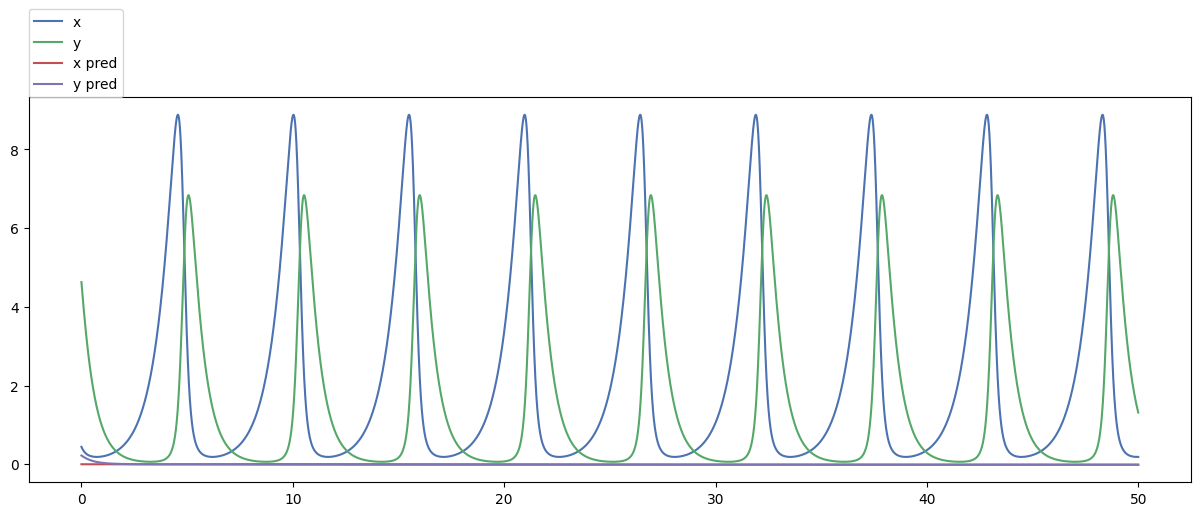

In [74]:
plt.style.use("seaborn-v0_8-deep")
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(t_test.detach().numpy(), x_test, label='x')
ax.plot(t_test.detach().numpy(), y_test, label='y')
with torch.no_grad():
    out = pinn(t_test.reshape(-1,1))
ax.plot(t_test.detach().numpy(), out[:,0], label='x pred')
ax.plot(t_test.detach().numpy(), out[:,1], label='y pred')
ax.legend(loc=(0,1))
fig.show()

In [29]:
out = pinn(t_test.reshape(-1,1))
out.shape

torch.Size([100000, 2])

In [108]:
torch.vstack(measurements)

TypeError: vstack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [109]:
nn.MSELoss()(tmp, torch.Tensor([[0,0,0],[0,0,0],[0,0,0],[0,0,0]]))

tensor(22.7500)

In [ ]:
a = 3

In [ ]:
out = pinn(t_train.reshape(-1,1))

In [24]:
dudt = torch.autograd.grad(out, t_train, torch.ones_like(out), create_graph=True)

In [25]:
dudt

(tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
         0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
         0.0009, 0.0009], grad_fn=<ReshapeAliasBackward0>),)

In [26]:
dxdt = torch.autograd.grad(out[:,0], t_train, torch.ones_like(out[:,0]), create_graph=True)
dydt = torch.autograd.grad(out[:,1], t_train, torch.ones_like(out[:,1]), create_graph=True)

In [27]:
(dxdt[0] + dydt[0])

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009], grad_fn=<AddBackward0>)

In [28]:
dudt[0]

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009], grad_fn=<ReshapeAliasBackward0>)

In [29]:
0.0027 - 0.0027

0.0